This notebook will demonstrate how to use the **constrained training algorithms** implemented in this toolkit with **PyTorch**-like API.

The algorithms implemented in the **humancompatible.train.torch** subpackage share a similar idea. Before the training, you initialize an algorithm like you would a PyTorch one. Then, during the training process, you:

1. Evaluate a constraint and compute its gradient
2. Call the `dual_step` function to update dual parameters and save the constraint gradient for the primal update
3. Call the `step` function to update the primal parameters (generally, model weights)

Let's try the Stochastic Smooth Linearized Augmented Lagrangian (SSLALM) algorithm on a constrained learning task.

Let's train a simple classification model, putting a constraint on the norm of each layer's parameters.

In the canonical form, the algorithm expects equality constraints that are equal to 0; however, we can easily transform arbitrary inequality constraints to that form.

In [1]:
# load and prepare data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncome.features, definition_df=definition_df
)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(
    acs_data, categories=categories, dummies=True
)

sens_cols = ["SEX_Female", "SEX_Male"]
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")
# split
# indices - used later
indices = np.arange(len(features))
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42
)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [2]:
import torch
from humancompatible.train.dual_optim.alm import ALM
from humancompatible.train.dual_optim.moreau import MoreauEnvelope
# from humancompatible.train.dual_optim.alm_pr import ALM
from torch.nn import Sequential
torch.manual_seed(0)

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=False)

hsize1 = 32
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

optimizer = MoreauEnvelope(
    torch.optim.Adam(model.parameters()),
)

# optimizer = torch.optim.Adam(model.parameters())

m = len(list(model.parameters()))
alm = ALM(m=6, lr=0.1)

# alm.add_constraint_group(m=2)
constraint_bounds = [1.0] * m
epochs = 4
criterion = torch.nn.BCEWithLogitsLoss()

model(dataset_train[0][0]).backward()
model.zero_grad()

In [4]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        constraints = []
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(norm - constraint_bounds[i], torch.zeros(1, requires_grad=True))
            constraints.append(norm_viol)
            c_log[-1].append(norm.detach().numpy())

        constraints = torch.cat(constraints)
        batch_output = model(batch_input)
        bce_loss = criterion(batch_output, batch_label)
        
        lag_loss = alm.forward_update(bce_loss, constraints)
        lag_loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        loss_log.append(bce_loss.detach().numpy())
        duals_log.append(alm.duals)

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.46967172622680664, constraints: [0.99916095 0.85705286 0.99455    0.68658775 0.98663807 0.10671731], dual: [0.21296914 0.01612437 0.22169231 0.         0.15678324 0.        ]
Epoch: 1, loss: 0.445394366979599, constraints: [0.99981254 0.9993942  0.9940762  0.84345114 0.99903065 0.11519367], dual: [0.31852347 0.04102766 0.32268658 0.         0.20959671 0.        ]
Epoch: 2, loss: 0.437930703163147, constraints: [0.9995397  0.99938405 0.9958783  0.96915007 0.99910116 0.11517022], dual: [3.9132753e-01 4.8751738e-02 3.8036436e-01 1.4522477e-04 2.3987973e-01
 0.0000000e+00]
Epoch: 3, loss: 0.43382036685943604, constraints: [0.9992904  0.9992571  0.9957076  0.99766016 0.99910635 0.1154544 ], dual: [0.45449296 0.05429585 0.42745516 0.00275809 0.26691532 0.        ]


In [13]:
from humancompatible.train.optim import SSLALM_Adam
import torch
from torch.nn import Sequential
torch.manual_seed(0)

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=False)

hsize1 = 32
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

m = len(list(model.parameters()))

optimizer = SSLALM_Adam(params=model.parameters(), m=m, lr=1e-3, dual_lr=0.1)
# bounds for the constraints: norm of each param group should be <= 1
constraint_bounds = [1.0] * m

epochs = 4
criterion = torch.nn.BCEWithLogitsLoss()

model(dataset_train[0][0]).backward()
model.zero_grad()

In [14]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        constraints = []
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(norm - constraint_bounds[i], torch.zeros(1, requires_grad=True))
            # for the Lagrangian family of algorithms, dual_step requires the index of constraint and the value as arguments
            # to update the corresponding dual multiplier
            # in a stochastic-constrained setting, this estimate needs (in theory) to be independent from the one used to update dual parameters
            # in practice, it makes little difference
            constraints.append(norm_viol)
            c_log[-1].append(norm.detach().numpy())

        constraints = torch.cat(constraints)

        # calculate loss and grad
        # if using `implicit_backward_in_step`, the `step` function calculates the Lagrangian 
        # with given loss and constraint values, as well as its gradient
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        optimizer.dual_steps(constraints)
        optimizer.step(loss, constraints)
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4714626669883728, constraints: [0.9909032  0.839815   0.9977387  0.6772365  0.9833519  0.10743531], dual: [0.22460327 0.03351351 0.26980013 0.         0.18063588 0.        ]
Epoch: 1, loss: 0.435590922832489, constraints: [0.9998326  0.999242   0.9952602  0.7747835  0.9991491  0.10837803], dual: [0.28774178 0.0408992  0.33229193 0.         0.21279947 0.        ]
Epoch: 2, loss: 0.42737847566604614, constraints: [0.9996763  0.99932694 0.9953302  0.84194446 0.99916077 0.10243133], dual: [0.3457188  0.04526534 0.3823107  0.         0.2377712  0.        ]
Epoch: 3, loss: 0.4232760965824127, constraints: [0.9994817  0.9991852  0.99528074 0.9013012  0.9991106  0.09461335], dual: [0.39703715 0.04870771 0.42716923 0.         0.26259863 0.        ]


In [ ]:
import torch

t = torch.ones(1, requires_grad=True)

def modified_log_barrier(t):
    return -torch.log(1-t)

def modified_log_barrier_derivative(t):
    return 1 / (1-t)

barrier = modified_log_barrier

def test_autograd(t):
    penalty_barrier_val = barrier(t)
    dloss_dt = torch.autograd.grad(penalty_barrier_val, t, retain_graph=True)[0]
    return dloss_dt

def test_analytic(t):
    dloss_dt = modified_log_barrier_derivative(t)
    return dloss_dt

In [10]:
import time

total = 0
grad = 0

torch.manual_seed(1)
n = 100000

for i in range(n):
    t = torch.rand(1, requires_grad=True)
    start = time.perf_counter()
    # grad += test_autograd(t)
    grad += test_analytic(t)
    total += time.perf_counter() - start 

print(total / n)
print(grad / n)

1.2804412419854998e-05
tensor([14.0488], grad_fn=<DivBackward0>)


In [31]:
import torch

# t1 = torch.ones(100, requires_grad=True)

def val(t1):
    return torch.sum(t1).pow(3)

def mor_grad(t1, t2):
    return t1 - t2

def val_mor(t1, t2):
    return val(t1) + 0.5*torch.linalg.norm(t1 - t2).square()

def test_autograd(t1, t2):
    v = val_mor(t1, t2)
    v.backward()
    dloss_dt = t1.grad
    return dloss_dt

def test_analytic(t1, t2):
    v = val(t1)
    v.backward()
    dloss_dt = t1.grad
    dloss_dt += mor_grad(t1, t2)
    return dloss_dt

In [36]:
import time

total = 0
grad = 0

torch.manual_seed(1)
n = 100000

for i in range(n):
    t1 = torch.rand(100, requires_grad=True)
    t2 = torch.rand(100, requires_grad=True)
    start = time.perf_counter()
    grad += test_autograd(t1, t2)
    # grad += test_analytic(t1, t2)
    total += time.perf_counter() - start 

print(total / n)
print(torch.sum(grad / n))

7.589513078906747e-05
tensor(752387.2500)


In [37]:
import time

total = 0
grad = 0

torch.manual_seed(1)
n = 100000

for i in range(n):
    t1 = torch.rand(100, requires_grad=True)
    t2 = torch.rand(100, requires_grad=True)
    start = time.perf_counter()
    # grad += test_autograd(t1, t2)
    grad += test_analytic(t1, t2)
    total += time.perf_counter() - start 

print(total / n)
print(torch.sum(grad / n))

4.199198879836331e-05
tensor(752387.2500, grad_fn=<SumBackward0>)


The model is now trained subject to the constraints we set.

In [11]:
optimizer.state_dict()['state'][5]

{'smoothing': tensor([0.6234]),
 'step': tensor(23080.),
 'exp_avg': tensor([-0.0044]),
 'exp_avg_sq': tensor([0.0115])}

---
---

It is also possible to train a network subject to **stochastic constraints**. One of the main use-cases for that is **fairness**. Let's train a network on the `folktables` dataset without constraints first, so we can identify some biases:

Define a model:

In [12]:
from torch.nn import Sequential

hsize1 = 64
hsize2 = 32
model_uncon = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

And start training:

In [13]:
from torch.optim import Adam

loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model_uncon.parameters())
epochs = 50

for epoch in range(epochs):
    losses = []
    for batch_feat, batch_label in loader:
        optimizer.zero_grad()

        logit = model_uncon(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.4543383255549368
Epoch: 1, loss: 0.3957279000727776
Epoch: 2, loss: 0.38296317796393664
Epoch: 3, loss: 0.3735677656108533
Epoch: 4, loss: 0.36317036999550656
Epoch: 5, loss: 0.3534308093435624
Epoch: 6, loss: 0.3415915298317543
Epoch: 7, loss: 0.328489128074844
Epoch: 8, loss: 0.3158695147111754
Epoch: 9, loss: 0.30217014882185056
Epoch: 10, loss: 0.2881197530814933
Epoch: 11, loss: 0.2752904527946327
Epoch: 12, loss: 0.26087372221542476
Epoch: 13, loss: 0.25012918430216174
Epoch: 14, loss: 0.23713452268430518
Epoch: 15, loss: 0.22633877788448004
Epoch: 16, loss: 0.21566144477537347
Epoch: 17, loss: 0.20700655490881845
Epoch: 18, loss: 0.19832052878236275
Epoch: 19, loss: 0.19020307711148343
Epoch: 20, loss: 0.1821976952435236
Epoch: 21, loss: 0.174950062803228
Epoch: 22, loss: 0.17140272030265274
Epoch: 23, loss: 0.16434977492349784
Epoch: 24, loss: 0.15741345301837656
Epoch: 25, loss: 0.15284975141183726
Epoch: 26, loss: 0.14925392361351364
Epoch: 27, loss: 0.14362

In [14]:
from fairret.statistic import PositiveRate, TruePositiveRate
from fairret.loss import NormLoss

preds = torch.nn.functional.sigmoid(model_uncon(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3424, 0.4912], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

---
---

Now let us train the same model with one of the **constrained** training algorithms:

Here, to make sure each batch contains representatives of each protected group, we can use the BalancedBatchSampler from the `utils` subpackage - a custom PyTorch `Sampler` which yields an equal number of samples from each subgroup in each batch.

In [15]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [16]:
from torch.nn import Sequential

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

from humancompatible.train.optim import SSLALM_Adam

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.05,
    dual_bound=5,
    rho=1,
    mu=2,
)

# add slack variables
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

epochs = 50

As the constraint, we use `NormLoss` from `fairret`, which penalizes the model based on the ratio between the value of a statistic for each group and the overall value: $\sum_{s\in S}{|1-\frac{f(\theta, X_s, y_s)}{f(\theta, X, y)}|}$, where $S$ is the set of groups.

In [17]:
import pandas as pd
import random

ep_c_log = []


for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []

    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        # fair_constraint = torch.max(fair_loss + slack_vars[0] - fair_crit_bound, torch.zeros(1))
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        # fair_constraint.backward(retain_graph=True)

        optimizer.dual_step(0, c_val=fair_constraint)
        # optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        # calculate loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        # loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(loss, fair_constraint.unsqueeze(dim=0).to(torch.float))
        # optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

    optimizer.dual_lr *= 0.95
    ep_c_log.extend(c_log)

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.47457507252693176, constraints: [0.14870707], dual: [0.01171363]
Epoch: 1, loss: 0.4010746479034424, constraints: [0.19424376], dual: [-0.00815289]
Epoch: 2, loss: 0.387318879365921, constraints: [0.20019053], dual: [0.02694562]
Epoch: 3, loss: 0.37693294882774353, constraints: [0.19974901], dual: [0.0260496]
Epoch: 4, loss: 0.3689515292644501, constraints: [0.20213078], dual: [0.05064538]
Epoch: 5, loss: 0.36159637570381165, constraints: [0.20144874], dual: [0.07135803]
Epoch: 6, loss: 0.3556043207645416, constraints: [0.19592224], dual: [0.03350638]
Epoch: 7, loss: 0.34734177589416504, constraints: [0.20620165], dual: [0.09414508]
Epoch: 8, loss: 0.341912180185318, constraints: [0.19703408], dual: [0.06681126]
Epoch: 9, loss: 0.3331478536128998, constraints: [0.20166728], dual: [0.08144002]
Epoch: 10, loss: 0.32549625635147095, constraints: [0.19839155], dual: [0.06806353]
Epoch: 11, loss: 0.31708821654319763, constraints: [0.20088196], dual: [0.07503658]
Epoch: 12,

In [18]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3741, 0.4549], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [19]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.1942, dtype=torch.float64, grad_fn=<SumBackward0>)

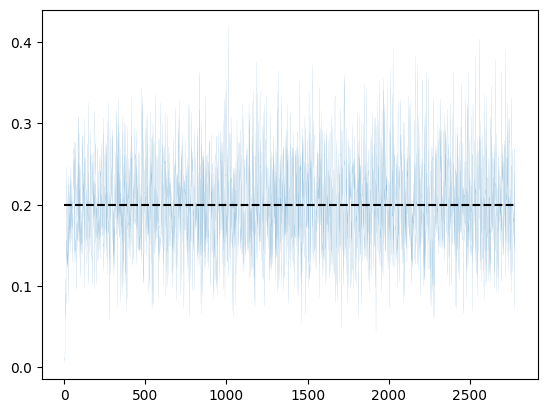

In [20]:
from matplotlib import pyplot as plt

window_len = 5
c_mavg = np.array(
    [np.mean(ep_c_log[i : i + window_len]) for i in range(0, len(ep_c_log), window_len)]
)
plt.plot(np.array(c_mavg).flatten(), lw=0.05)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors="black", ls="--")

---

Now let's see how the **Switching Subgradient** algorithm deals with this task.

In [21]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [22]:
from humancompatible.train.optim import SSG

from torch.nn import Sequential

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

optimizer = SSG(params=model_con.parameters(), m=1, lr=0.05, dual_lr=0.05)

epochs = 150

In [23]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)

        optimizer.dual_step(0)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        # calculate loss and grad
        # batch_output = model_con(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()

    ep_c_log.append(c_log)

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.6137531995773315, constraints: [0.03574553], 
Epoch: 1, loss: 0.4432542026042938, constraints: [0.11208739], 
Epoch: 2, loss: 0.42165082693099976, constraints: [0.10997515], 
Epoch: 3, loss: 0.41437721252441406, constraints: [0.11989843], 
Epoch: 4, loss: 0.4066804349422455, constraints: [0.11970544], 
Epoch: 5, loss: 0.3998471200466156, constraints: [0.12335672], 
Epoch: 6, loss: 0.39866214990615845, constraints: [0.11747267], 
Epoch: 7, loss: 0.3967738449573517, constraints: [0.12254281], 
Epoch: 8, loss: 0.39308813214302063, constraints: [0.11235712], 
Epoch: 9, loss: 0.3868701756000519, constraints: [0.11980889], 
Epoch: 10, loss: 0.3867383301258087, constraints: [0.12335022], 
Epoch: 11, loss: 0.3886414170265198, constraints: [0.11997224], 
Epoch: 12, loss: 0.3837997615337372, constraints: [0.12207551], 
Epoch: 13, loss: 0.3809055984020233, constraints: [0.12320655], 
Epoch: 14, loss: 0.377836138010025, constraints: [0.11777773], 
Epoch: 15, loss: 0.3769906759262

In [24]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.4330, 0.4689], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [25]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.0795, dtype=torch.float64, grad_fn=<SumBackward0>)

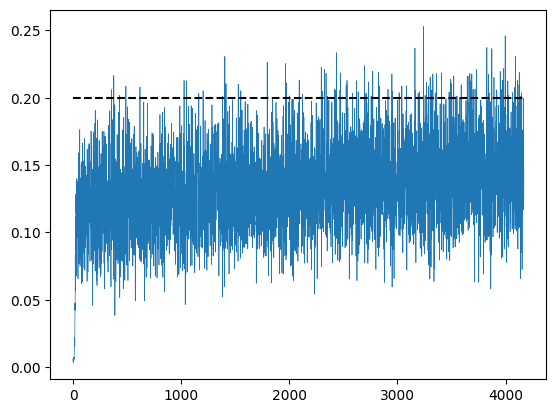

In [26]:
from matplotlib import pyplot as plt

ep_c_log = np.array(ep_c_log).flatten()
window_len = 10
c_mavg = np.array(
    [np.mean(ep_c_log[i : i + window_len]) for i in range(0, len(ep_c_log), window_len)]
)
plt.plot(np.array(c_mavg).flatten(), lw=0.5)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors="black", ls="--")